In [1]:
import numpy as np
from scipy.integrate import cumtrapz
import astropy.constants as const
import astropy.units as u

import h5py

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

In [4]:
fidhz = 1 / u.yr
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                          * (const.c ** 2)
                                          * (fidhz ** (4. / 3.)))

# Load data

## AGN-based model

In [5]:
with h5py.File('../data/processed/agn_proxy.h5', 'r') as hf:
    log_m_bh_range = hf['log_m_bh_range'][:]
    z_range = hf['z_range'][:]
    q_range = hf['q_range'][:]
    differential_bhb_population = hf['population'][:]
    hc = hf['characteristic_strain'][:]
    differential_number_density = hf['number_density'][:]
    local_bhmf = hf['local_bhmf'][:]

## S1

In [6]:
# the mass and the mass ratio ranges for all models are shared, so we will only load them once
with h5py.File('../data/processed/S1.h5', 'r') as hf:
    z_range_borch = hf['z_range'][:]
    S1_bhb_population = hf['population'][:]
    S1_hc = hf['characteristic_strain'][:]
    S1_number_density = hf['number_density'][:]
    S1_local_bhmf = hf['local_bhmf'][:]

## S2

In [7]:
with h5py.File('../data/processed/S2.h5', 'r') as hf:
    z_range_drory = hf['z_range'][:]
    S2_bhb_population = hf['population'][:]
    S2_hc = hf['characteristic_strain'][:]
    S2_number_density = hf['number_density'][:]
    S2_local_bhmf = hf['local_bhmf'][:]

## S3

In [8]:
with h5py.File('../data/processed/S3.h5', 'r') as hf:
    z_range_ilbert = hf['z_range'][:]
    S3_bhb_population = hf['population'][:]
    S3_hc = hf['characteristic_strain'][:]
    S3_number_density = hf['number_density'][:]
    S3_local_bhmf = hf['local_bhmf'][:]

# Analysis

## AGN-based model

In [9]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [10]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1 / 3)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [11]:
hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''),
                                               log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

hc_q_bounds = np.quantile(hc_bounds, q=[.16, .5, .84], axis=-1)

In [12]:
# negative sign on m and q integration because we integrate them in reverse order (max to min) to
# explore their lower bounds. In the full integral they cancel out, but here we need to account
# for this explicitely
dhc_dm = -(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                             x=z_range, axis=1, initial=0)) / (2 * np.log(10) * hc_bounds * (10 ** mm[::-1, ..., np.newaxis]))
dhc_dm_q = np.quantile(dhc_dm, q=[.16, .5, .84], axis=-1)

dhc_dz = (cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                            x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
dhc_dz_q = np.quantile(dhc_dz, q=[.16, .5, .84], axis=-1)

dhc_dq = -(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=z_range, axis=1, initial=0),
                             x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
dhc_dq_q = np.quantile(dhc_dq, q=[.16, .5, .84], axis=-1)

<ipython-input-12-255e3a0c0af6>:4: RuntimeWarning: divide by zero encountered in true_divide
  dhc_dm = -(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-12-255e3a0c0af6>:4: RuntimeWarning: invalid value encountered in true_divide
  dhc_dm = -(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
/Users/jacaseyclyde/miniconda3/envs/mm_smbhbs/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
<ipython-input-12-255e3a0c0af6>:8: RuntimeWarning: divide by zero encountered in true_divide
  dhc_dz = (cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-12-255e3a0c0af6>:8: RuntimeWarning: invalid value encountered in true_divide
  dhc_dz = (cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-

## S1

In [13]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [14]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1 / 3)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [15]:
S1_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_borch, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S1_hc_q_bounds = np.quantile(S1_hc_bounds, q=[.16, .5, .84], axis=-1)

In [16]:
# negative sign on m and q integration because we integrate them in reverse order (max to min) to
# explore their lower bounds. In the full integral they cancel out, but here we need to account
# for this explicitely
S1_dhc_dm = -(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                             x=z_range_borch, axis=1, initial=0)) / (2 * np.log(10) * hc_bounds * (10 ** mm[::-1, ..., np.newaxis]))
S1_dhc_dm_q = np.quantile(S1_dhc_dm, q=[.16, .5, .84], axis=-1)

S1_dhc_dz = (cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                            x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S1_dhc_dz_q = np.quantile(S1_dhc_dz, q=[.16, .5, .84], axis=-1)

S1_dhc_dq = -(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_borch, axis=1, initial=0),
                             x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S1_dhc_dq_q = np.quantile(S1_dhc_dq, q=[.16, .5, .84], axis=-1)

<ipython-input-16-35cb7662b234>:4: RuntimeWarning: divide by zero encountered in true_divide
  S1_dhc_dm = -(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-16-35cb7662b234>:4: RuntimeWarning: invalid value encountered in true_divide
  S1_dhc_dm = -(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-16-35cb7662b234>:8: RuntimeWarning: divide by zero encountered in true_divide
  S1_dhc_dz = (cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-16-35cb7662b234>:8: RuntimeWarning: invalid value encountered in true_divide
  S1_dhc_dz = (cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-16-35cb7662b234>:12: RuntimeWarning: divide by zero encountered in true_divide
  S1_dhc_dq = -(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_

## S2

In [17]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [18]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [19]:
S2_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_drory, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S2_hc_q_bounds = np.quantile(S2_hc_bounds, q=[.16, .5, .84], axis=-1)

In [20]:
# negative sign on m and q integration because we integrate them in reverse order (max to min) to
# explore their lower bounds. In the full integral they cancel out, but here we need to account
# for this explicitely
S2_dhc_dm = -(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                             x=z_range_drory, axis=1, initial=0)) / (2 * np.log(10) * hc_bounds * (10 ** mm[::-1, ..., np.newaxis]))
S2_dhc_dm_q = np.quantile(S2_dhc_dm, q=[.16, .5, .84], axis=-1)

S2_dhc_dz = (cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                            x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S2_dhc_dz_q = np.quantile(S2_dhc_dz, q=[.16, .5, .84], axis=-1)

S2_dhc_dq = -(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_drory, axis=1, initial=0),
                             x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S2_dhc_dq_q = np.quantile(S2_dhc_dq, q=[.16, .5, .84], axis=-1)

<ipython-input-20-341cf3341c3b>:4: RuntimeWarning: divide by zero encountered in true_divide
  S2_dhc_dm = -(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-20-341cf3341c3b>:4: RuntimeWarning: invalid value encountered in true_divide
  S2_dhc_dm = -(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-20-341cf3341c3b>:8: RuntimeWarning: divide by zero encountered in true_divide
  S2_dhc_dz = (cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-20-341cf3341c3b>:8: RuntimeWarning: invalid value encountered in true_divide
  S2_dhc_dz = (cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-20-341cf3341c3b>:12: RuntimeWarning: divide by zero encountered in true_divide
  S2_dhc_dq = -(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_

## S3

In [21]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [22]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [23]:
S3_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_ilbert, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S3_hc_q_bounds = np.quantile(S3_hc_bounds, q=[.16, .5, .84], axis=-1)

In [24]:
# negative sign on m and q integration because we integrate them in reverse order (max to min) to
# explore their lower bounds. In the full integral they cancel out, but here we need to account
# for this explicitely
S3_dhc_dm = -(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                             x=z_range_ilbert, axis=1, initial=0)) / (2 * np.log(10) * hc_bounds * (10 ** mm[::-1, ..., np.newaxis]))
S3_dhc_dm_q = np.quantile(S3_dhc_dm, q=[.16, .5, .84], axis=-1)

S3_dhc_dz = (cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
                            x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S3_dhc_dz_q = np.quantile(S3_dhc_dz, q=[.16, .5, .84], axis=-1)

S3_dhc_dq = -(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_ilbert, axis=1, initial=0),
                             x=log_m_bh_range[::-1], axis=0, initial=0)) / (2 * hc_bounds)
S3_dhc_dq_q = np.quantile(S3_dhc_dq, q=[.16, .5, .84], axis=-1)

<ipython-input-24-402e8a9dabda>:4: RuntimeWarning: divide by zero encountered in true_divide
  S3_dhc_dm = -(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-24-402e8a9dabda>:4: RuntimeWarning: invalid value encountered in true_divide
  S3_dhc_dm = -(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-24-402e8a9dabda>:8: RuntimeWarning: divide by zero encountered in true_divide
  S3_dhc_dz = (cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-24-402e8a9dabda>:8: RuntimeWarning: invalid value encountered in true_divide
  S3_dhc_dz = (cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=q_range[::-1], axis=2, initial=0),
<ipython-input-24-402e8a9dabda>:12: RuntimeWarning: divide by zero encountered in true_divide
  S3_dhc_dq = -(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''), x=z_range_

# Plot

In [25]:
z_sat = z_range[hc_q_bounds[1, -1, :, -1] >= 0.95 * hc_q_bounds[1, -1, -1, -1]][0]
log_m_sat = log_m_bh_range[::-1][(hc_q_bounds[1, :, z_range == z_sat, -1] >= 0.95 * hc_q_bounds[1, -1, z_range == z_sat, -1])[0]][0]
z_sat, log_m_sat

(2.5161290322580645, 8.161290322580644)

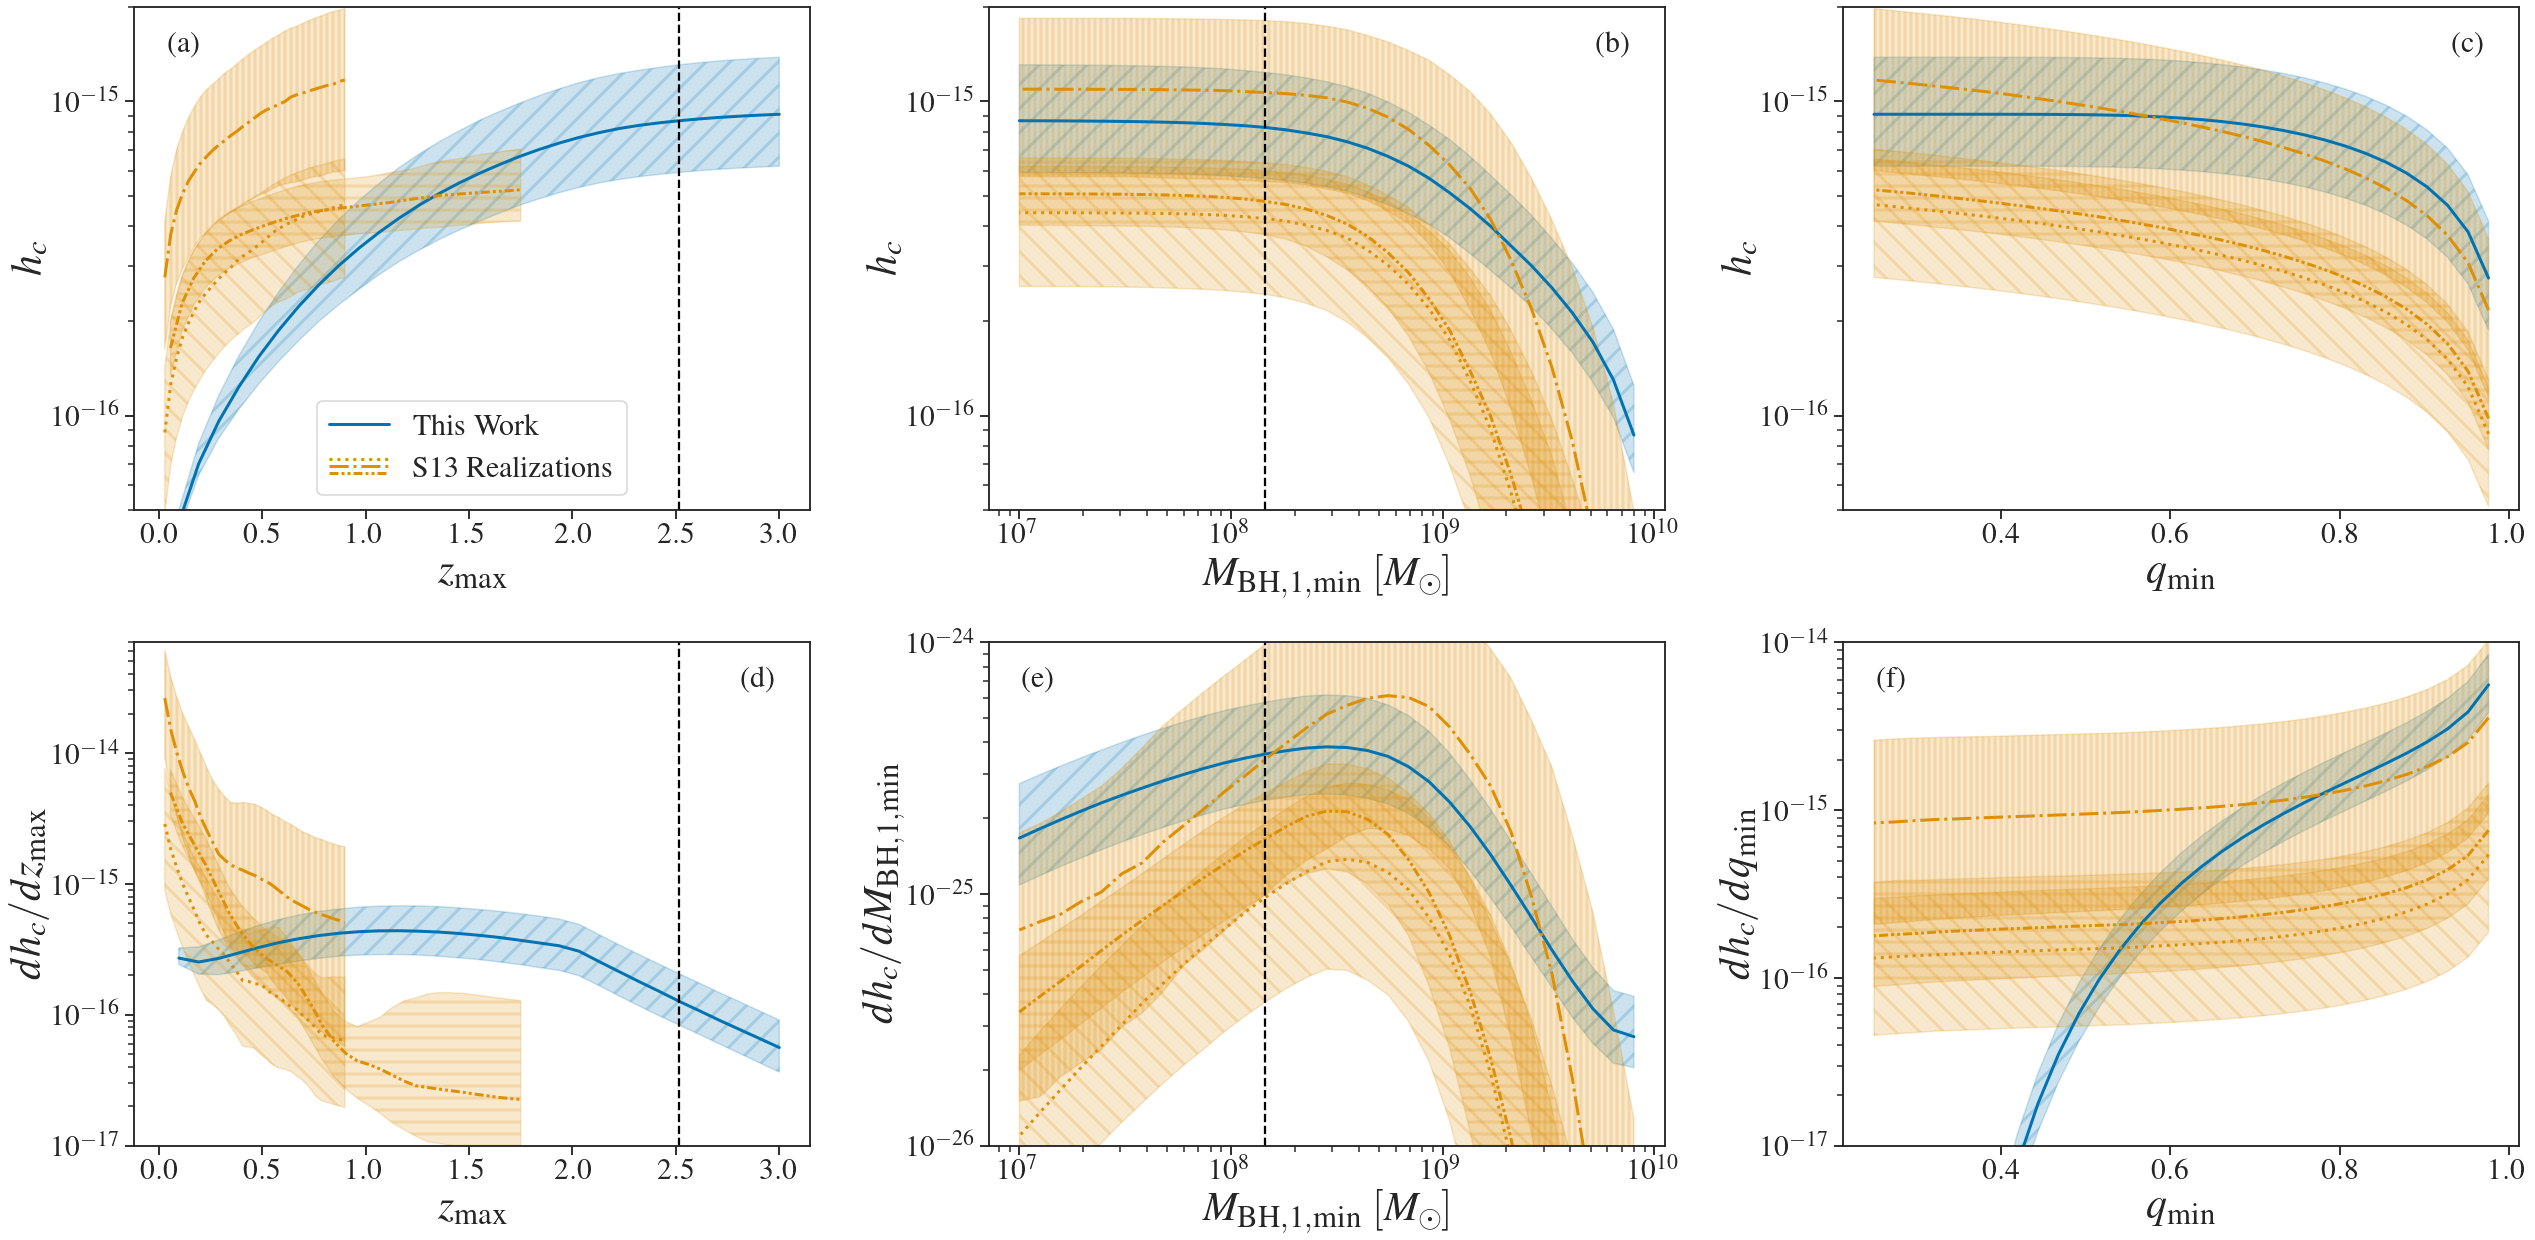

In [32]:
label_fsize = 42
legend_fsize = 30

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(2, 3, figsize=(36, 18))

m1, = ax[0, 0].plot(z_range[z_range <= 3][1:],
         hc_q_bounds[..., z_range <= 3, :][1, -1, 1:, -1].flatten(), color=cs[0],
         linewidth=3)
ax[0, 0].fill_between(z_range[z_range <= 3][1:],
                 hc_q_bounds[..., z_range <= 3, :][0, -1, 1:, -1].flatten(),
                 hc_q_bounds[..., z_range <= 3, :][2, -1, 1:, -1].flatten(), color=cs[0], alpha=0.2, hatch='/')

s1, = ax[0, 0].plot(z_range_borch[1:],
         S1_hc_q_bounds[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[0, 0].fill_between(z_range_borch[1:],
                 S1_hc_q_bounds[0, -1, 1:, -1].flatten(),
                 S1_hc_q_bounds[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='\\')
s2, = ax[0, 0].plot(z_range_drory[1:],
         S2_hc_q_bounds[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[0, 0].fill_between(z_range_drory[1:],
                 S2_hc_q_bounds[0, -1, 1:, -1].flatten(),
                 S2_hc_q_bounds[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='||')
s3, = ax[0, 0].plot(z_range_ilbert[1:],
         S3_hc_q_bounds[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0, 0].fill_between(z_range_ilbert[1:],
                 S3_hc_q_bounds[0, -1, 1:, -1].flatten(),
                 S3_hc_q_bounds[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[0, 0].axvline(z_sat, color='k', linestyle='--')
ax[0, 0].set_xlabel(r'$z_{\rm{max}}$', fontsize=label_fsize)
ax[0, 0].set_ylabel(r'$h_{c}$', fontsize=label_fsize)
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(top=2e-15, bottom=5e-17)

ax[0, 0].legend([m1, (s1, s2, s3)], ['This Work', 'S13 Realizations'], numpoints=1,
                 handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=True, loc='lower center', fontsize=legend_fsize)
ax[0, 0].text(.05, .95, '(a)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='left', transform=ax[0, 0].transAxes)


ax[1, 0].plot(z_range[z_range <= 3][1:],
         dhc_dz_q[..., z_range <= 3, :][1, -1, 1:, -1].flatten(), color=cs[0],
         linewidth=3)
ax[1, 0].fill_between(z_range[z_range <= 3][1:],
                 dhc_dz_q[..., z_range <= 3, :][0, -1, 1:, -1].flatten(),
                 dhc_dz_q[..., z_range <= 3, :][2, -1, 1:, -1].flatten(), color=cs[0], alpha=0.2, hatch='/')

ax[1, 0].plot(z_range_borch[1:],
         S1_dhc_dz_q[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[1, 0].fill_between(z_range_borch[1:],
                 S1_dhc_dz_q[0, -1, 1:, -1].flatten(),
                 S1_dhc_dz_q[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='\\')
ax[1, 0].plot(z_range_drory[1:],
         S2_dhc_dz_q[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[1, 0].fill_between(z_range_drory[1:],
                 S2_dhc_dz_q[0, -1, 1:, -1].flatten(),
                 S2_dhc_dz_q[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='||')
ax[1, 0].plot(z_range_ilbert[1:],
         S3_dhc_dz_q[1, -1, 1:, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[1, 0].fill_between(z_range_ilbert[1:],
                 S3_dhc_dz_q[0, -1, 1:, -1].flatten(),
                 S3_dhc_dz_q[2, -1, 1:, -1].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[1, 0].axvline(z_sat, color='k', linestyle='--')
ax[1, 0].set_xlabel(r'$z_{\rm{max}}$', fontsize=label_fsize)
ax[1, 0].set_ylabel(r'$d h_{c} / d z_{\rm{max}}$', fontsize=label_fsize)
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(top=7e-14, bottom=1e-17)
ax[1, 0].text(.95, .95, '(d)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[1, 0].transAxes)


ax[0, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         hc_q_bounds[1, 1:, z_range == z_sat, -1].flatten(), color=cs[0],
         linewidth=3)
ax[0, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                 hc_q_bounds[0, 1:, z_range == z_sat, -1].flatten(),
                 hc_q_bounds[2, 1:, z_range == z_sat, -1].flatten(), color=cs[0], alpha=0.2, hatch='/')

ax[0, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S1_hc_q_bounds[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[0, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                      S1_hc_q_bounds[0, 1:, z_range == z_sat, -1].flatten(),
                      S1_hc_q_bounds[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='\\')
ax[0, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S2_hc_q_bounds[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[0, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                      S2_hc_q_bounds[0, 1:, z_range == z_sat, -1].flatten(),
                      S2_hc_q_bounds[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='||')
ax[0, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S3_hc_q_bounds[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                      S3_hc_q_bounds[0, 1:, z_range == z_sat, -1].flatten(),
                      S3_hc_q_bounds[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[0, 1].axvline(10 ** log_m_sat, color='k', linestyle='--')
ax[0, 1].set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
ax[0, 1].set_ylabel(r'$h_{c}$', fontsize=label_fsize)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylim(top=2e-15, bottom=5e-17)
ax[0, 1].text(.95, .95, '(b)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0, 1].transAxes)


ax[1, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         dhc_dm_q[1, 1:, z_range == z_sat, -1].flatten(), color=cs[0],
         linewidth=3)
ax[1, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                 dhc_dm_q[0, 1:, z_range == z_sat, -1].flatten(),
                 dhc_dm_q[2, 1:, z_range == z_sat, -1].flatten(), color=cs[0], alpha=0.2, hatch='/')

ax[1, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S1_dhc_dm_q[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[1, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                 S1_dhc_dm_q[0, 1:, z_range == z_sat, -1].flatten(),
                 S1_dhc_dm_q[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='\\')
ax[1, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S2_dhc_dm_q[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[1, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                 S2_dhc_dm_q[0, 1:, z_range == z_sat, -1].flatten(),
                 S2_dhc_dm_q[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='||')
ax[1, 1].plot(10 ** (log_m_bh_range[::-1][1:]),
         S3_dhc_dm_q[1, 1:, z_range == z_sat, -1].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[1, 1].fill_between(10 ** (log_m_bh_range[::-1][1:]),
                 S3_dhc_dm_q[0, 1:, z_range == z_sat, -1].flatten(),
                 S3_dhc_dm_q[2, 1:, z_range == z_sat, -1].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[1, 1].axvline(10 ** log_m_sat, color='k', linestyle='--')
ax[1, 1].set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
ax[1, 1].set_ylabel(r'$d h_{c} / d M_{\rm{BH}, 1, \min}$', fontsize=label_fsize)
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylim(top=1e-24, bottom=1e-26)
ax[1, 1].text(.05, .95, '(e)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='left', transform=ax[1, 1].transAxes)


ax[0, 2].plot(q_range[::-1][1:],
         hc_q_bounds[1, -1, -1, 1:].flatten(), color=cs[0],
         linewidth=3)
ax[0, 2].fill_between(q_range[::-1][1:],
                 hc_q_bounds[0, -1, -1, 1:].flatten(),
                 hc_q_bounds[2, -1, -1, 1:].flatten(), color=cs[0], alpha=0.2, hatch='/')

ax[0, 2].plot(q_range[::-1][1:],
         S1_hc_q_bounds[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[0, 2].fill_between(q_range[::-1][1:],
                 S1_hc_q_bounds[0, -1, -1, 1:].flatten(),
                 S1_hc_q_bounds[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='\\')
ax[0, 2].plot(q_range[::-1][1:],
         S2_hc_q_bounds[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[0, 2].fill_between(q_range[::-1][1:],
                 S2_hc_q_bounds[0, -1, -1, 1:].flatten(),
                 S2_hc_q_bounds[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='||')
ax[0, 2].plot(q_range[::-1][1:],
         S3_hc_q_bounds[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0, 2].fill_between(q_range[::-1][1:],
                 S3_hc_q_bounds[0, -1, -1, 1:].flatten(),
                 S3_hc_q_bounds[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[0, 2].set_xlabel(r'$q_{\rm{min}}$', fontsize=label_fsize)
ax[0, 2].set_ylabel(r'$h_{c}$', fontsize=label_fsize)
# ax[0, 2].set_xscale('log')
ax[0, 2].set_yscale('log')
ax[0, 2].set_ylim(top=2e-15, bottom=5e-17)
ax[0, 2].text(.95, .95, '(c)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0, 2].transAxes)


ax[1, 2].plot(q_range[::-1][1:],
         dhc_dq_q[1, -1, -1, 1:].flatten(), color=cs[0],
         linewidth=3)
ax[1, 2].fill_between(q_range[::-1][1:],
                 dhc_dq_q[0, -1, -1, 1:].flatten(),
                 dhc_dq_q[2, -1, -1, 1:].flatten(), color=cs[0], alpha=0.2, hatch='/')

ax[1, 2].plot(q_range[::-1][1:],
         S1_dhc_dq_q[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle=':')
ax[1, 2].fill_between(q_range[::-1][1:],
                 S1_dhc_dq_q[0, -1, -1, 1:].flatten(),
                 S1_dhc_dq_q[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='\\')
ax[1, 2].plot(q_range[::-1][1:],
         S2_dhc_dq_q[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle='-.')
ax[1, 2].fill_between(q_range[::-1][1:],
                 S2_dhc_dq_q[0, -1, -1, 1:].flatten(),
                 S2_dhc_dq_q[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='||')
ax[1, 2].plot(q_range[::-1][1:],
         S3_dhc_dq_q[1, -1, -1, 1:].flatten(), color=cs[1],
         linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[1, 2].fill_between(q_range[::-1][1:],
                 S3_dhc_dq_q[0, -1, -1, 1:].flatten(),
                 S3_dhc_dq_q[2, -1, -1, 1:].flatten(), color=cs[1], alpha=0.2, hatch='-')
ax[1, 2].set_xlabel(r'$q_{\rm{min}}$', fontsize=label_fsize)
ax[1, 2].set_ylabel(r'$d h_{c} / d q_{\rm{min}}$', fontsize=label_fsize)
ax[1, 2].set_yscale('log')
ax[1, 2].set_ylim(top=1e-14, bottom=1e-17)
ax[1, 2].text(.05, .95, '(f)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='left', transform=ax[1, 2].transAxes)


plt.tight_layout()
plt.savefig('../reports/figures/extending_bounds.pdf')
plt.savefig('../reports/figures/extending_bounds.png')
plt.show()